## Observed heterozygosity / ML Relate (verified)

#### Batch 8

The purpose of this notebook is to combine observed heterozygosity and ML Relate to identify potentially contaminated individuals that I should leave out of the analysis. 

ML Relate does this really interesting thing where it only allows you to include 1-2 populations in your genepop file. I found some helpful documentation on that: "Input files can have either one or two POP's (to use the GENEPOP term) in them. If the file has one POP, ML-Relate will estimate allele frequencies in the population from the individuals whose relatedness is being estimated. If the file has two POP's the first POP will be used to estimate allele frequencies and the second POP should contain the individuals to analzye. See the user's manual for more details. "

I'll first run a genepop file with all samples as a single population, to identify samples contaminated between populations. I'll then run genepop files for each population through. 

If ML Relate does not identify all replicates as full siblings, I'll assume that it is not identifying relatedness correctly for that population, and disregard the results. 

<br>
Summary of this notebook: 
1. Plot observed heterozygosity against read depth and missing data
2. Identify individuals with high heterozygosity
3. Run ML Relate on population as a whole, parse results & identify full / half siblings between populations
4. Run ML Relate on each region (East / South / West), parse results & identify full / half siblings between populations.
5. For each group of samples that were identified as full / half sibs, I did the following: 
        a. Count the number of replicates correctly identified as full-sibs and remove them from sibling list
        b. Identify samples that are being removed because of high heterozygosity, and remove any pairs involving those samples from the sibling list
        c. Remove any full sibling pairs from analysis
        d. For each of the remaining half-sibling pairs, gather the following information for each sample: Heterozygosity, % genotypes missing, location on extraction plate, location on RAD plate. 
        e. If the samples were next to each other on the RAD or extraction plate, remove those samples from analysis.
        f. If the samples were not next to each other on the RAD or extraction plate, but one or both samples had slightly elevated heterozygosity (> 0.20) or a relatively high percentage of genotypes missing (>0.10), write each sample name down to keep an eye on through the rest of the analysis. 
        g. Any sibling pairs left were assumed to be a false positive, or a result of lower variation within sampling sites than between sampling sites in the same region. 
        
*Samples that were flagged for high heterozygosity close to the cutoff of 0.25 that did NOT show up in the region-based ML relate runs, were retained for analysis*


<br>
<br>
<br>



#### 3/7/2018

In [7]:
cd ../analyses

/mnt/hgfs/PCod-Korea-repo/analyses


In [8]:
!python calc_het.py -h

usage: calc_het.py [-h] [-l LIST] [-i IND] [-f FILE] [-o OUTPUT]
                   [-d DENOMINATOR]

optional arguments:
  -h, --help            show this help message and exit
  -l LIST, --list LIST  Population map, or any white space delimited list of
                        individuals with sample name in first column
  -i IND, --ind IND     name of individual to investigate (mutually exclusive
                        to '-l' and requires '-f') - UNTESTED
  -f FILE, --file FILE  location of file with genotypes (assumes genepop
                        format)
  -o OUTPUT, --output OUTPUT
                        name of output file
  -d DENOMINATOR, --denominator DENOMINATOR
                        use 2 if counting a FASTA file or 4 if counting a
                        FASTQ file


In [13]:
!python calc_het.py \
-l ../scripts/PopMap_L1-5_mdFilter_b8_verif.txt \
-f ../stacks_b8_verif/batch_8_filteredMAF_filteredIndivids30_filteredLoci_filteredHWE_genepop.txt \
-o Het_Depth_MissingData_b8_verif.txt \
-d 4

In [14]:
!python calc_missing_genotypes.py -h

usage: calc_missing_genotypes.py [-h] [-l LIST] [-i IND] [-f FILE] [-o OUTPUT]
                                 [-d DENOMINATOR]

optional arguments:
  -h, --help            show this help message and exit
  -l LIST, --list LIST  Population map, or any white space delimited list of
                        individuals with sample name in first column
  -i IND, --ind IND     name of individual to investigate (mutually exclusive
                        to '-l' and requires '-f') - UNTESTED
  -f FILE, --file FILE  location of file with genotypes (assumes genepop
                        format)
  -o OUTPUT, --output OUTPUT
                        name of output file
  -d DENOMINATOR, --denominator DENOMINATOR
                        use 2 if counting a FASTA file or 4 if counting a
                        FASTQ file


In [15]:
!python calc_missing_genotypes.py \
-l ../scripts/PopMap_L1-5_mdFilter_b8_verif.txt \
-f ../stacks_b8_verif/batch_8_filteredMAF_filteredIndivids30_filteredLoci_filteredHWE_genepop.txt \
-o MissingData_b8_verif.txt \
-d 4

*I already had read depths, so I manually combined the above into a single file. *

In [16]:
## open file and save each number into appropriate list ##
infile = open("Het_Depth_MissingData_b8_verif.txt", "r")
het_dict = {}
het = []
reads = []
missing = []
infile.readline()
for line in infile:
    linelist = line.strip().split()
    het_dict[linelist[0]] = float(linelist[1])
    het.append(float(linelist[1]))
    reads.append(float(linelist[2]))
    missing.append(float(linelist[3]))
infile.close()

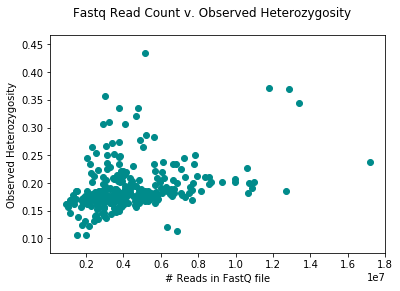

In [17]:
import numpy as np 
import matplotlib.pyplot as plt
plt.scatter(reads, het, color = "darkcyan")
plt.suptitle("Fastq Read Count v. Observed Heterozygosity")
plt.xlabel("# Reads in FastQ file")
plt.ylabel("Observed Heterozygosity")
plt.show()

In [18]:
plt.close()

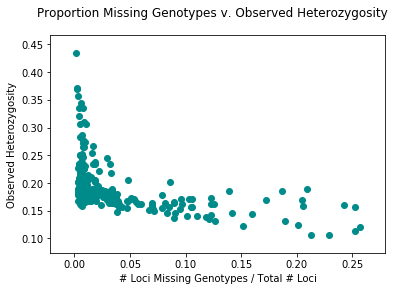

In [19]:
import numpy as np 
import matplotlib.pyplot as plt
plt.scatter(missing, het, color = "darkcyan")
plt.suptitle("Proportion Missing Genotypes v. Observed Heterozygosity")
plt.xlabel("# Loci Missing Genotypes / Total # Loci")
plt.ylabel("Observed Heterozygosity")
plt.show()

In [20]:
plt.close()

In [21]:
outfile = open("batch_8_HighLowHet_verif.txt", "w")
outfile.write("# Individuals with very high (possible contam) or very low (possible missing data) heterozygosity\n")

low_het_individs = {}
high_het_individs = {}

for sample in het_dict.keys():
    if float(het_dict[sample]) > 0.25:
        high_het_individs[sample] = het_dict[sample]
    elif float(het_dict[sample]) < 0.13:
        low_het_individs[sample] = het_dict[sample]

outfile.write("\n# High Heterozygosity\n")
for i in high_het_individs.keys():
    outfile.write(i + "\t" + str(high_het_individs[i]) + "\n")
    
outfile.write("\n# Low Heterozygosity\n")
for i in low_het_individs.keys():
    outfile.write(i + "\t" + str(low_het_individs[i]) + "\n")
outfile.close()

<br>
Individuals with heterozygosity near the cutoff that did NOT appear in ML relate (and so were retained):

PO031715_13.1

<br>
<br>
### ML Relate - One Pop

#### FILE: batch_8_filteredMAF_filteredIndivids30_filteredLoci_filteredHWE_onepop.txt

Calculate relatedness using `Relationship` >> `Relatedness` >> `List Output`

In [22]:
pwd

u'/mnt/hgfs/PCod-Korea-repo/analyses'

In [23]:
cd ml_relate/batch_8_verif/

/mnt/hgfs/PCod-Korea-repo/analyses/ml_relate/batch_8_verif


In [24]:
infile = open("MLrelate_b8_all.txt", "r")
outfile = open("MLrelate_b8_all_relatedIndivids.txt", "w")

outfile.write("relatedness\tsample1\tsample2\n")

for line in infile:
    if line.startswith("Ind1"):
        break

r_count = 0
u_count = 0

halfsibs = ""
hs_count = 0
fullsibs = ""
fs_count = 0
for line in infile:
    linelist = line.strip().split()
    if len(linelist) > 2:
        relate = linelist[2]
        if relate == "HS":
            halfsibs += relate + "\t" + linelist[0] + "\t" + linelist[1] + "\n"
            r_count += 1
            hs_count += 1
        elif relate == "FS":
            fullsibs += relate + "\t" + linelist[0] + "\t" + linelist[1] + "\n"
            r_count += 1
            fs_count += 1
        else:
            u_count += 1
infile.close()

outfile.write(fullsibs)
outfile.write(halfsibs)
outfile.close()

print r_count, " detected related pairs: ", hs_count, " half sib pairs & ", fs_count, " full sib pairs."
print u_count, " unrelated pairs"

130  detected related pairs:  81  half sib pairs &  49  full sib pairs.
44123  unrelated pairs


**By looking at the pairs in excel, I found that:**

(1) ML Relate caught 42/45 replicates. this is a good sign for it's reliability on this run!

(2) The following samples were identified as related across different *regions* +:

* HS:	YS_121316_21 |||	PO010715_26 << second sample removed b/c of high heterozygosity
* HS:	JB121807_21.1 |||	JUK07_31 << both heterozygosities normal; not close on plates. will retain both.

`JB121807_21.1`
<br>
Ho = 0.170208799
<br>
Prop. Missing Genotypes = 0.050827016
<br>
E plate = 3; A5
<br>
RAD plate = 17,18,20-22 (Sublib 21); Lane 4
<br>
<br>
`JUK07_31`
<br>
Ho = 0.181455114
<br>
Prop. Missing Genotypes = 0.007753274
<br>
E plate = 1/12/16; C12
<br>
RAD plate = 16,24-26; Lane 5
<br>
<br>
<br>

+preliminary analyses show little differentiation detectable within regions, so I will wait to assess those sibling pairs until I have a separate genepop file for each; higher likelihood here that non-related individuals within regions will be identified as related 

<br>
### ML Relate, by region

In [25]:
pwd

u'/mnt/hgfs/PCod-Korea-repo/analyses/ml_relate/batch_8_verif'

In [27]:
cd ../../../

/mnt/hgfs/PCod-Korea-repo


In [3]:
# open original genepop, create new genepops
infile = open("stacks_b8_wgenome/batch_8_filteredMAF_filteredIndivids30_filteredLoci_filteredHWE.gen", "r")
southfile = open("analyses/ml_relate/batch_8/batch_8.filteredMAF_filteredIndivids30_filteredLoci_filteredHWE_south.txt", "w")
eastfile = open("analyses/ml_relate/batch_8/batch_8.filteredMAF_filteredIndivids30_filteredLoci_filteredHWE_east.txt", "w")
westfile = open("analyses/ml_relate/batch_8/batch_8.filteredMAF_filteredIndivids30_filteredLoci_filteredHWE_west.txt", "w")


pop_count = 0

heading = "#"

#save the title line of the genepop, all of the loci, and the first incidence of "Pop" to an object.
#then write that as the heading for all new genepop files.
for line in infile:
    if not line.startswith("Pop"):
        heading += line
    else:
        heading += line
        break

southfile.write(heading)
eastfile.write(heading)
westfile.write(heading)
        
#separate individuals into the appropriate genepop file using the sample site abbrevs. in sample name
for line in infile:
    if line.startswith("PO") or line.startswith("JB") or line.startswith("NA") or line.startswith("GE"):
        southfile.write(line)
    elif line.startswith("YS") or line.startswith("BOR"):
        westfile.write(line)
    elif line.startswith("JUK"):
        eastfile.write(line)
        
        
infile.close()
southfile.close()
westfile.close()
eastfile.close()

### --- South

In [28]:
cd analyses/ml_relate/batch_8_verif/

/mnt/hgfs/PCod-Korea-repo/analyses/ml_relate/batch_8_verif


In [33]:
infile = open("MLrelate_b8_south.txt", "r")
outfile = open("MLrelate_b8_south_relatedIndivids.txt", "w")

outfile.write("relatedness\tsample1\tsample2\n")

for line in infile:
    if line.startswith("Ind1"):
        break

r_count = 0
u_count = 0

halfsibs = ""
hs_count = 0
fullsibs = ""
fs_count = 0
for line in infile:
    linelist = line.strip().split()
    if len(linelist) > 2:
        relate = linelist[2]
        if relate == "HS":
            halfsibs += relate + "\t" + linelist[0] + "\t" + linelist[1] + "\n"
            r_count += 1
            hs_count += 1
        elif relate == "FS":
            fullsibs += relate + "\t" + linelist[0] + "\t" + linelist[1] + "\n"
            r_count += 1
            fs_count += 1
        else:
            u_count += 1
infile.close()

outfile.write(fullsibs)
outfile.write(halfsibs)
outfile.close()

print r_count, " detected related pairs: ", hs_count, " half sib pairs & ", fs_count, " full sib pairs."
print u_count, " unrelated pairs"

123  detected related pairs:  90  half sib pairs &  33  full sib pairs.
14928  unrelated pairs


**By looking at the pairs in excel, I found that:**

(1) ML Relate caught 29/35 replicates as full sibs. This is ok, but not ideal. Fairly good sign for it's reliability on this run, will not explore all half-sib pairs.

(2) I explored samples for contamination if: a. they were full sibling pairs, b. They were identified as in sibling relationships more than three times throughout the list, and c. They were identified as in sibling relationships three times throughout the list AND across sampling sites

<br>
<br>

This was a little unweidly for Jupyter Notebooks, so see [this excel spreadsheet]() for breakdown of heterozygosity, missing data, and plate locations

<br>
<br>

(3) Samples to remove:

* GE012315_06.1
* GE012315_05.1
* GE012315_09.1
* GE012315_11_2
* GE011215_30.1
* GE012315_11.1
* NA021015_06_2
* NA021015_09_2
* NA021015_10_2
* NA021015_13.1
* NA021015_06.1
* NA021015_10.1
* NA021015_09.1
* GE012315_04.1


(4) Samples to keep an eye on:

* JB121807_30_2
* JB121807_05_2
* JB121807_39
* JB021108_20


### - East

In [30]:
infile = open("MLrelate_b8_east.txt", "r")
outfile = open("MLrelate_b8_east_relatedIndivids.txt", "w")

outfile.write("relatedness\tsample1\tsample2\n")

for line in infile:
    if line.startswith("Ind1"):
        break

r_count = 0
u_count = 0

halfsibs = ""
hs_count = 0
fullsibs = ""
fs_count = 0
for line in infile:
    linelist = line.strip().split()
    if len(linelist) > 2:
        relate = linelist[2]
        if relate == "HS":
            halfsibs += relate + "\t" + linelist[0] + "\t" + linelist[1] + "\n"
            r_count += 1
            hs_count += 1
        elif relate == "FS":
            fullsibs += relate + "\t" + linelist[0] + "\t" + linelist[1] + "\n"
            r_count += 1
            fs_count += 1
        else:
            u_count += 1
infile.close()

outfile.write(fullsibs)
outfile.write(halfsibs)
outfile.close()

print r_count, " detected related pairs: ", hs_count, " half sib pairs & ", fs_count, " full sib pairs."
print u_count, " unrelated pairs"

4  detected related pairs:  0  half sib pairs &  4  full sib pairs.
626  unrelated pairs


<br>

(1) ML Relate caught 4 / 4 replicates as full sibs

(2) No other sibling pairs were identified in this group. (YAY!!)

<br>

### --- West

In [31]:
infile = open("MLrelate_b8_west.txt", "r")
outfile = open("MLrelate_b8_west_relatedIndivids.txt", "w")

outfile.write("relatedness\tsample1\tsample2\n")

for line in infile:
    if line.startswith("Ind1"):
        break

r_count = 0
u_count = 0

halfsibs = ""
hs_count = 0
fullsibs = ""
fs_count = 0
for line in infile:
    linelist = line.strip().split()
    if len(linelist) > 2:
        relate = linelist[2]
        if relate == "HS":
            halfsibs += relate + "\t" + linelist[0] + "\t" + linelist[1] + "\n"
            r_count += 1
            hs_count += 1
        elif relate == "FS":
            fullsibs += relate + "\t" + linelist[0] + "\t" + linelist[1] + "\n"
            r_count += 1
            fs_count += 1
        else:
            u_count += 1
infile.close()

outfile.write(fullsibs)
outfile.write(halfsibs)
outfile.close()

print r_count, " detected related pairs: ", hs_count, " half sib pairs & ", fs_count, " full sib pairs."
print u_count, " unrelated pairs"

17  detected related pairs:  8  half sib pairs &  9  full sib pairs.
1414  unrelated pairs


<br>

(1) ML Relate correctly identified 6 / 6 replicates as full sibs 
<br>
<br>

(2) Samples to remove:
* YS_121316_20.1
* YS121315_14.1
* YS121315_14_2
* BOR07_10.1



(4) I need to keep an eye on the following samples: 
* YS121315_16
* YS_121316_19

<br>
<br>
<br>

### Additional samples removed for high heterozygosity

* PO031715_13.1
* PO010715_02_rep
* GE012315_10.1
* NA021015_03.1

<br>
#### for list of contaminated samples: scripts/Batch_8_verif_Samples_Reps_Contam_removed.txt

<br>
<br>
### New Genepop

In [1]:
pwd

u'/mnt/hgfs/PCod-Korea-repo/notebooks'

In [5]:
cd ../

/mnt/hgfs/PCod-Korea-repo


In [6]:
infile = open("stacks_b8_verif/batch_8_filteredMAF_filteredIndivids30_filteredLoci_filteredHWE_genepop.txt", "r")
samplefile = open("scripts/Batch_8_verif_Samples_Reps_Contam_removed.txt", "r")
outfile = open("stacks_b8_verif/batch_8_filteredMAF_filteredIndivids30_filteredLoci_filteredHWE_filteredC_genepop.txt", "w")

## get list of samples to remove
count = 0
samples_to_remove = []
for line in samplefile:
    if not line.startswith("#"):
        samples_to_remove.append(line.strip())
        count += 1
samplefile.close()
print "Removing ", count, " samples from file."

## remove those samples from genepop and write to new file
keep = 0
line = infile.readline()
while not line.startswith("Pop"):
    outfile.write(line)
    line = infile.readline()
outfile.write(line)
for line in infile:
    if line.startswith("Pop"):
        outfile.write(line)
    else:
        sample = line.strip().split()[0].strip(",")
        if sample not in samples_to_remove:
            outfile.write(line)
            keep += 1
print "Wrote ", keep, " samples to new file."
infile.close()
outfile.close()

Removing  20  samples from file.
Wrote  278  samples to new file.



<br>
<br>

#### FINAL SAMPLE LIST: `POPMAP_FINAL_noreps_noc.txt`